# Forex Rate Prediction - USD/JPY

This example is to predict the foreign exchange rate with Japan.

The data source is from Yahoo Finance.

The data availability is from 30th October 1996 to 31st January 2022.

There are seven columns in the csv files, they are "Date", "Open", "High", "Low", "Close", "Adj Close", "Volume".

## 1. Data Acquisition

In [1392]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

In [1393]:
# Reading dataset
forex_dataset = pd.read_csv('Data/Historical forex rate/JPY=X.csv')
forex_dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,30/10/1996,114.370003,114.480003,113.610001,114.180000,114.180000,0.0
1,31/10/1996,NaN,NaN,NaN,NaN,NaN,NaN
2,1/11/1996,113.500000,113.500000,113.500000,113.500000,113.500000,0.0
3,4/11/1996,113.279999,113.980003,112.949997,113.879997,113.879997,0.0
4,5/11/1996,113.709999,114.330002,113.449997,114.250000,114.250000,0.0


## 2. Exploratory Data Analysis

In [1394]:
forex_dataset.shape

(6589, 7)

In [1395]:
# Checking null values
forex_dataset.isnull().sum()

Date          0
Open         43
High         43
Low          43
Close        43
Adj Close    43
Volume       43
dtype: int64

In [1396]:
# Fill NaN values using an interpolation method ("linear")
forex_dataset.interpolate(inplace = True)

In [1397]:
# See if there is any difference between the values in "Close" and "Adj Close"
all(forex_dataset['Close']==forex_dataset['Adj Close']) and all(forex_dataset['Volume']<=0)

True

In [1398]:
# Drop out the "Adj Close" for redundancy
forex_dataset.drop(['Adj Close','Volume'], axis = 1, inplace = True)

In [1399]:
# Resort the date
forex_dataset['Date'] = pd.to_datetime(forex_dataset['Date'], format = '%d/%m/%Y')
forex_dataset.head()

,Date,Open,High,Low,Close
0,1996-10-30,114.370003,114.480003,113.610001,114.180000
1,1996-10-31,113.935001,113.990002,113.555001,113.840000
2,1996-11-01,113.500000,113.500000,113.500000,113.500000
3,1996-11-04,113.279999,113.980003,112.949997,113.879997
4,1996-11-05,113.709999,114.330002,113.449997,114.250000


In [1400]:
# See if duplicated row exists
forex_dataset.duplicated().sum()

0

In [1401]:
# Set the date to be the index
Date = forex_dataset['Date']
forex_dataset.set_index('Date', inplace= True) 

In [1402]:
# Show a summary of the data
forex_dataset.describe()

,Open,High,Low,Close
count,6589.000000,6589.000000,6589.000000,6589.000000
mean,108.613101,109.056737,108.123988,108.608502
std,13.219991,13.301232,13.131916,13.218674
min,75.750000,75.973999,75.570000,75.739998
25%,103.232002,103.699997,102.738998,103.225998
50%,109.804001,110.173668,109.410004,109.821999
75%,117.790001,118.269997,117.286003,117.790001
max,147.339996,147.630005,146.000000,147.220001


Text(0.5, 1.0, 'JPY Exchange Rate at All Time')

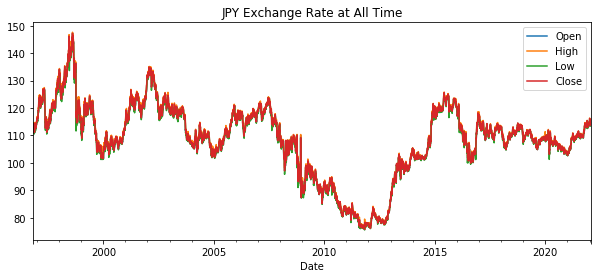

In [1403]:
# Plot the Janpanese yen exchange rate
forex_dataset[['Open','High','Low','Close']].plot(figsize = (10,4))
plt.title('JPY Exchange Rate at All Time')

Text(0.5, 0, 'JPY Exchange Rate')

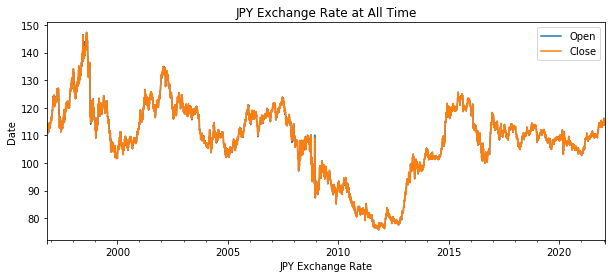

In [1404]:
forex_dataset[['Open','Close']].plot(figsize = (10,4))
plt.title('JPY Exchange Rate at All Time')
plt.ylabel('Date')
plt.xlabel('JPY Exchange Rate')

In [1405]:
# Show the correlation of the features
pd.DataFrame(forex_dataset.corr())

,Open,High,Low,Close
Open,1.000000,0.999398,0.999097,0.999018
High,0.999398,1.000000,0.998882,0.999344
Low,0.999097,0.998882,1.000000,0.999383
Close,0.999018,0.999344,0.999383,1.000000


In [1406]:
# Split the dataset into X and y, with looking back n days of data
# Features of the previous date and the 'Open' of next day are used to predict the closing value of the next day
def get_data(data, look_back, features): 
    X_data, y_data = [], []
    current_open = []
    for i in range(len(data)-look_back):
        X_data.append(data.iloc[i:(i+look_back),features].values.tolist()[0]) # :
        y_data.append(data.iloc[i+look_back,-1])
        
        # Add a feature for the current 'Open' price for a mulitple feature prediction
        if features not in ([-1],[3]):
            current_open.append(data.iloc[i+look_back,0])
            
    if len(current_open) == 0:
        return np.array(X_data).reshape(-1,1), np.array(y_data).reshape(-1,1)
    else:
        X_data = [np.append(X, X_open) for X, X_open in zip(X_data, current_open)]
        return np.array(X_data), np.array(y_data).reshape(-1,1)


In [1407]:
# define a function to split the training and testing datasets
from datetime import timedelta
from datetime import datetime

# Convert the string type of date into a datetime object, and find the start date for tesing
date1 = datetime.strptime('2020-12-31', '%Y-%m-%d').date()
if date1.weekday() == 5:
    testing_start_date = str(date1 + timedelta(days = 3))
else:
    testing_start_date = str(date1 + timedelta(days = 1))

forex_dataset['Date'] = forex_dataset.index
Dates = np.array(forex_dataset[testing_start_date:][['Date']]).reshape(-1,1)
forex_dataset.drop('Date', axis = 1, inplace = True)

In [1408]:
# Retrieve the training and testing datasets from forex_dataset
train_dataset = forex_dataset[:testing_start_date] 
test_dataset = forex_dataset[testing_start_date:] # so predict for values starting on testing_start_date

# use the function get_data
X_train, y_train = get_data(train_dataset, look_back = 1, features=[0,1,2,3])
X_test, y_test = get_data(test_dataset, look_back = 1, features=[0,1,2,3])

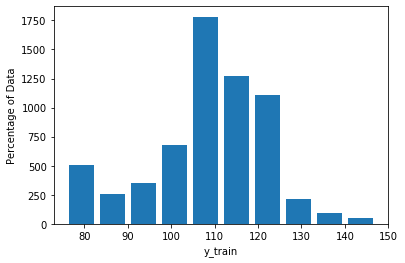

In [1412]:
# Show the distribution of the y_train data
plt.hist(y_train, bins = 10, rwidth=0.8)
plt.ylabel('Percentage of Data')
plt.xlabel('y_train');
plt.show()

In [1418]:
# Check if the data follows the normal distribution
from scipy.stats import shapiro
from scipy.stats import normaltest
print(normaltest(y_train))
print(shapiro(y_train))
# The first output is the test statistic, the second is the p-value
# If the p-Value is larger than 0.05, a normal distribution is assumed
## The Shapiro Wilk test is better for data size < 5000

NormaltestResult(statistic=array([270.4334724]), pvalue=array([1.88850268e-59]))
(0.9579125046730042, 2.7850484679808945e-39)


In [1311]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Reshape the 2D-array into 3D-array
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1);
y_train = y_train.reshape(-1,1,1)
y_test = y_test.reshape(-1,1,1);


In [1312]:
# Print the shapes of the training and testing datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((6307, 5, 1), (281, 5, 1), (6307, 1, 1), (281, 1, 1))

In [1313]:
# Plot the correlation map in another method (for mulitple features)
pd.DataFrame(X_train.reshape(-1,X_train.shape[1])).corr().style.background_gradient(cmap='coolwarm').set_precision(4)

,0,1,2,3,4
0,1,0.9994,0.9991,0.999,0.9982
1,0.9994,1,0.9989,0.9994,0.9989
2,0.9991,0.9989,1,0.9994,0.9989
3,0.999,0.9994,0.9994,1,0.9992
4,0.9982,0.9989,0.9989,0.9992,1


## 3. Building the Model

In [1314]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import callbacks
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences = False, input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
model.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 64)                16896     
                                                                 
 dense_93 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [1315]:
# Compiling
model.compile(optimizer = 'adam', loss = 'mse')

In [1316]:
# Training the model
early_stopping = callbacks.EarlyStopping(min_delta = 0.001, patience= 5, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), batch_size = 8, callbacks=[early_stopping])

Epoch 1/10
789/789 [==============================] - 10s 9ms/step - loss: 0.0052 - val_loss: 2.1560e-05
Epoch 2/10
789/789 [==============================] - 6s 8ms/step - loss: 1.3591e-04 - val_loss: 1.3926e-05
Epoch 3/10
789/789 [==============================] - 6s 8ms/step - loss: 1.4014e-04 - val_loss: 1.9502e-05
Epoch 4/10
789/789 [==============================] - 6s 8ms/step - loss: 1.3643e-04 - val_loss: 1.9750e-04
Epoch 5/10
789/789 [==============================] - 6s 8ms/step - loss: 1.4648e-04 - val_loss: 9.9893e-06
Epoch 6/10
789/789 [==============================] - 6s 8ms/step - loss: 1.3655e-04 - val_loss: 1.1387e-05


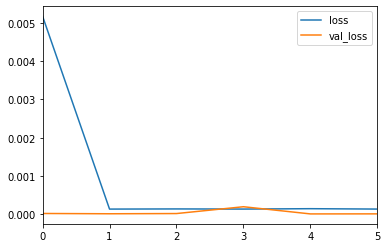

In [1317]:
history_df = pd.DataFrame(history.history)
history_df.plot()

In [1318]:
# The standard deviations
scaler_X.scale_

array([0.01396843, 0.01395556, 0.01419849, 0.01398993, 0.01396843])

In [1319]:
# Prediction using the trained model
y_train_pred = model.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred)

y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
# Process the features shape
y_train = y_train.reshape(-1,1)
y_train = scaler_y.inverse_transform(y_train)

y_test = y_test.reshape(-1,1)
y_test = scaler_y.inverse_transform(y_test)
pd.DataFrame(
  {'pred': y_pred.tolist(),
   'test': y_test.tolist()
}).head(5)

,pred,test
0,[103.009033203125],[103.238998]
1,[102.8847427368164],[103.125]
2,[102.73677062988281],[102.678001]
3,[102.65342712402344],[103.024002]
4,[103.11600494384766],[103.790001]


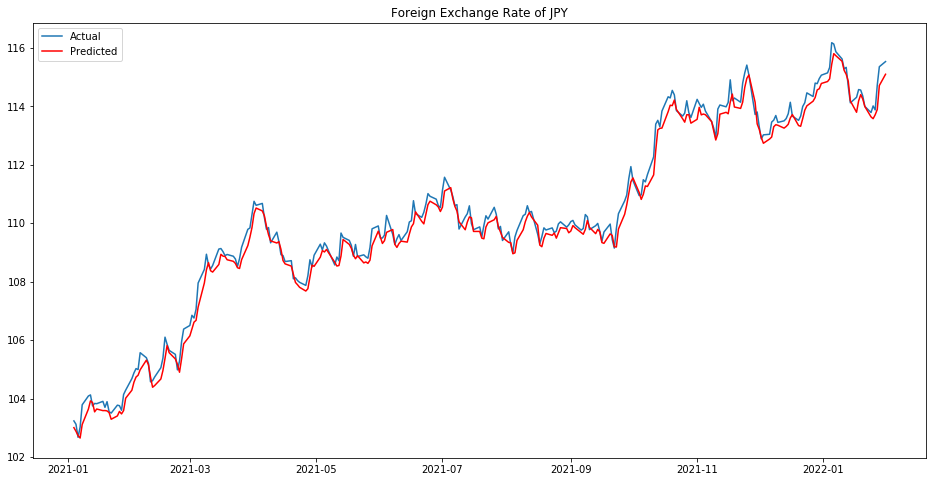

In [1320]:
# Visualize the result
plt.figure(figsize=(16,8))
plt.title('Foreign Exchange Rate of JPY')
plt.plot(testing_days[1:], y_test, label='Actual')
plt.plot(testing_days[1:], y_pred, label='Predicted', color = 'r')
plt.legend()

In [1321]:
# Evalute the root mean squared error result of the y_pred, and y_train_pred
pred_mse_result = np.sqrt(np.mean(abs(y_test-y_pred)**2))
train_pred_mse_result = np.sqrt(np.mean(abs(y_train_pred - y_train)**2))
pred_mse_result, train_pred_mse_result

(0.3319014395061675, 0.8001032159698838)

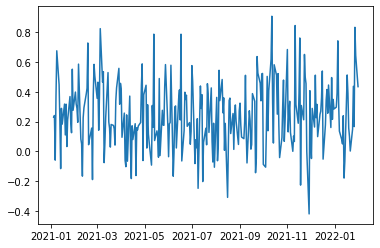

In [1322]:
# Take a look at the deviation from the actual price
plt.plot(testing_days[1:],y_test-y_pred)

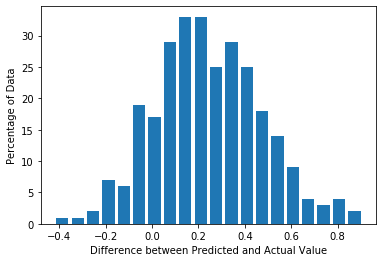

In [1323]:
# Show the distribution of the deviation
plt.hist(y_test-y_pred, bins = 20, rwidth=0.8)
plt.ylabel('Percentage of Data')
plt.xlabel('Difference between Actual and Predicted Value');
plt.show()

In [1324]:
# Record whether the prediction and testing data has an increase or decrease for each testing date
daily_y_pred_change = []
daily_y_test_change = []
daily_complying_sign = []
y_pred_list = y_pred.reshape(1,-1).tolist()[0]
y_test_list = y_test.reshape(1,-1).tolist()[0]
for i, pred in enumerate(y_pred_list):
    if pred != y_pred_list[-1]:
        daily_y_pred_change.append(y_pred_list[i+1] - y_pred_list[i])
        daily_y_test_change.append(y_test_list[i+1] - y_test_list[i])

        if (daily_y_pred_change[i] >= 0 and daily_y_test_change[i] >=0) or (daily_y_pred_change[i] < 0 and daily_y_test_change[i] < 0):
            daily_complying_sign.append(1)
        else:
            daily_complying_sign.append(0)

In [1325]:
daily_y_pred_change, daily_y_test_change, daily_complying_sign = sign_prediction(y_pred, y_test)
# 1 denotes as predicted corrected for the change of sign, while 0 means the opposite
daily_complying_sign.count(1)/len(daily_complying_sign)

0.6642857142857143

# Predictions after tuning the LSTM model

### Notes: 
1. Dropout on stacked LSTMs yields poor performance, as it introduces too much noise for stable time-dependency feature extraction. Fix: use recurrent_dropout, meanwhile, use activation='tanh' instead of 'relu' which is unstable
2. If working with signal data, or otherwise data with (1) outliers; (2) phase information; (3) frequency information - MinMaxScaler will corrupt the latter two plus amplitude information per (1). Fix: use StandardScaler, or QuantileTransformer


In [1424]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from datetime import timedelta
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import callbacks

In [1426]:
# Function to split the dataset into X and y, with looking back n days of data and selected features
# Features of the previous date and the 'Open' of next day are used to predict the closing value of the next day
def get_data(data, look_back, features): 
    X_data, y_data = [], []
    current_open = []
    for i in range(len(data)-look_back):
        X_data.append(data.iloc[i:(i+look_back),features].values.tolist()[0]) # :
        y_data.append(data.iloc[i+look_back,-1])
        
        # Add a feature for the current 'Open' price for a mulitple feature prediction
        if features not in ([-1],[3]):
            current_open.append(data.iloc[i+look_back,0])
            
    if len(current_open) == 0:
        return np.array(X_data).reshape(-1,1), np.array(y_data).reshape(-1,1)
    else:
        X_data = [np.append(X, X_open) for X, X_open in zip(X_data, current_open)]
        return np.array(X_data), np.array(y_data).reshape(-1,1)

# Function to split the training and testing datasets from the X and y datasets, with normalization
def spliting_dataset(forex_dataset, training_end_date, look_back, features, normalization):
    
    # Convert the string type of date into a datetime object, and find the start date for tesing
    date1 = datetime.strptime(training_end_date, '%Y-%m-%d').date()
    if date1.weekday() == 5:
        testing_start_date = str(date1 + timedelta(days = 3))
    else:
        testing_start_date = str(date1 + timedelta(days = 1))
        
    forex_dataset['Date'] = forex_dataset.index
    Dates = forex_dataset[testing_start_date:][['Date']]
    forex_dataset.drop('Date', axis = 1, inplace = True)
    
    # Retrieve the training and testing datasets from forex_dataset
    train_dataset = forex_dataset[:testing_start_date] 
    test_dataset = forex_dataset[testing_start_date:] # so as to predict the values starting from the testing_start_date
    
    # use the function get_data
    X_train, y_train = get_data(train_dataset, look_back = look_back, features=features)
    X_test, y_test = get_data(test_dataset, look_back = look_back, features=features)
    
    # Normalization
    scaler_X = normalization
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    
    scaler_y = normalization
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    # Reshape the 2D-array into 3D-array
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1);
    y_train = y_train.reshape(-1,1,1)
    y_test = y_test.reshape(-1,1,1);
    
    return (X_train, X_test, y_train, y_test), np.array(Dates).reshape(-1,1), (scaler_X, scaler_y)

# Function to easily tune the achitecture for the LSTM model
def model_architecture(no_of_LSTM_layers, no_of_Dense_layers, no_of_nodes, activation, n_dropout, opt, loss, epochs, batch_size):    
    model = Sequential()
    for i in range(no_of_LSTM_layers):
        if i < no_of_LSTM_layers-1 and no_of_LSTM_layers >= 2:
            model.add(LSTM(no_of_nodes[0][i], activation = activation, return_sequences = True, input_shape=(X_train.shape[1],1), recurrent_dropout=n_dropout))
        elif no_of_LSTM_layers == 1:
            model.add(LSTM(no_of_nodes[0][i], activation = activation, return_sequences = False, input_shape=(X_train.shape[1],1), recurrent_dropout=n_dropout))
        else:
            model.add(LSTM(no_of_nodes[0][i], activation = activation, return_sequences = False, dropout=n_dropout, recurrent_dropout=n_dropout))
            
    for i in range(no_of_Dense_layers):
        if i < no_of_Dense_layers-1 and no_of_Dense_layers >= 2:
            model.add(Dense(no_of_nodes[1][i], activation = activation))
            model.add(Dropout(n_dropout))
        else:
            model.add(Dense(no_of_nodes[1][i]))
    
    model.summary()
    model.compile(optimizer = opt, loss = loss)
    early_stopping = callbacks.EarlyStopping(min_delta = 0.0001, patience= 5, restore_best_weights = True)
    model.fit(X_train, y_train, epochs = epochs, validation_data = (X_test, y_test), batch_size = batch_size, callbacks=[early_stopping])
    return model

# Function to record whether the prediction correctly predicts the price sign of change for each testing day
def sign_prediction(y_pred, y_test):
    daily_y_pred_change = []
    daily_y_test_change = []
    daily_complying_sign = []
    y_pred_list = y_pred.reshape(1,-1).tolist()[0]; y_test_list = y_test.reshape(1,-1).tolist()[0]
    for i, pred in enumerate(y_pred_list):
        if pred != y_pred_list[-1]:
            daily_y_pred_change.append(y_pred_list[i+1] - y_pred_list[i])
            daily_y_test_change.append(y_test_list[i+1] - y_test_list[i])

            if (daily_y_pred_change[i] >= 0 and daily_y_test_change[i] >=0) or (daily_y_pred_change[i] < 0 and daily_y_test_change[i] < 0):
                daily_complying_sign.append(1)
            else:
                daily_complying_sign.append(0)
    return daily_y_pred_change, daily_y_test_change, daily_complying_sign

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 5, 64)             16896     
                                                                 
 lstm_101 (LSTM)             (None, 32)                12416     
                                                                 
 dense_104 (Dense)           (None, 32)                1056      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_105 (Dense)           (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1577/1577 [===========================

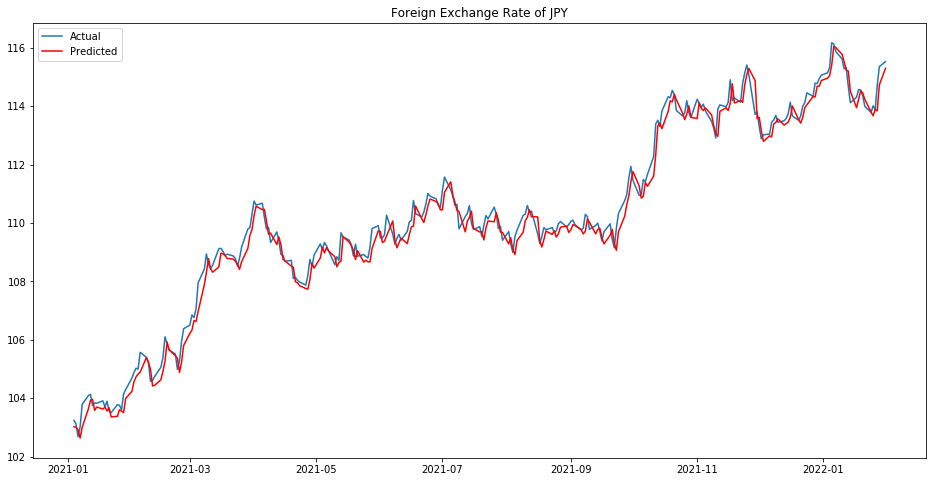

In [1427]:
def main_function(forex_dataset, training_end_date):
    
    look_back = 1
    features = [0,1,2,3]
    normalization = StandardScaler() # StandardScaler() or MinMaxScaler()
    
    no_of_LSTM_layers = 2
    no_of_Dense_layers = 2
    no_of_nodes = [[64,32],[32,1]]
    activation = 'tanh'
    n_dropout = 0.5

    opt = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.MeanSquaredError()
    epochs = 20
    batch_size = 4
    
    (X_train, X_test, y_train, y_test), testing_days, (scaler_X, scaler_y) = spliting_dataset(forex_dataset, training_end_date, look_back, features, normalization)
    model = model_architecture(no_of_LSTM_layers, no_of_Dense_layers, no_of_nodes, activation, n_dropout, opt, loss, epochs, batch_size)
    y_pred = model.predict(X_test)
    y_test = y_test.reshape(-1,1)
    mse_result = mean_squared_error(y_test, y_pred)
    daily_pred_change, daily_test_change, sign_change = sign_prediction(y_pred, y_test)
    sign_change_acc = sign_change.count(1)/len(sign_change)
    
    
    # Visualize the result
    plt.figure(figsize=(16,8))
    plt.title('Foreign Exchange Rate of JPY')
    plt.plot(testing_days[1:], mon_y_test, label='Actual')
    plt.plot(testing_days[1:], mon_y_pred, label='Predicted', color = 'r')
    plt.legend()
    print(f'The prediction mse result is {mse_result:0.4f}, and the daily sign prediction accuracy is {sign_change_acc*100:2.1f}%.')
    return model, (X_train, X_test, y_train, y_test, y_pred), mse_result, sign_change_acc

final_model, (X_train, X_test, y_train, y_test, y_pred), mse_result, sign_change_acc = main_function(forex_dataset, '2020-12-31')

In [1423]:
# Result for MinMaxScaler
mse_result, sign_change_acc

(0.0009737798975807138, 0.6678571428571428)

In [ ]:
# # Writing result to an Excel file
# from openpyxl import load_workbook
# filename_result = 'Result/Forex Prediction Result.xlsx'
# wb_result = load_workbook(filename_result)
# ws_result = wb_result.worksheets[0]

# # Title
# ws_result['A1'] = 'Analysis Date'
# ws_result['B1'] = 'Testing period'
# ws_result['C1'] = 'LSTM Architecture' 
# ws_result['D1'] = 'MSE Result'

# for i in range(1,10000):
#     if ws_result['A'+str(i+1)] != '':
#         ws_result['A'+str(i+1)] = today
# wb_result.save(filename_result)

In [ ]:
# from datetime import date

# today = date.today()
# print("Today's date:", today)